In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Any
import json
import time
from test_pid_controller import PIDTester

In [ ]:
class NumpyEncoder(json.JSONEncoder):
    """Custom encoder for numpy data types"""
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                          np.int16, np.int32, np.int64, np.uint8,
                          np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [ ]:
class PIDControllerBenchmark:
    def __init__(self):
        """Initialize benchmark environment and PID controller"""
        self.pid_tester = PIDTester(use_visualization=False)
        
        # Define test positions
        self.test_positions = [
            np.array([-0.0871, 0.0890, 0.1190]),  # Left
            np.array([-0.0571, 0.1590, 0.1190]),  # Top-left
            np.array([0.0730, 0.1790, 0.1190]),   # Top
            np.array([0.1830, 0.1590, 0.1190]),   # Top-right
            np.array([0.2130, 0.0890, 0.1190]),   # Right
            np.array([0.1830, -0.0810, 0.1190]),  # Bottom-right
            np.array([0.0730, -0.1105, 0.1190]),  # Bottom
            np.array([-0.0571, -0.0810, 0.1190])  # Bottom-left
        ]

    def benchmark_pid(self) -> Dict[str, Any]:
        """
        Benchmark PID controller
        
        Returns:
            Dictionary containing performance metrics
        """
        all_metrics = []
        trajectory_data = []
        
        for i, target_pos in enumerate(self.test_positions):
            print(f"\nTesting PID controller - Position {i+1}/{len(self.test_positions)}")
            
            # Reset environment
            obs, _ = self.pid_tester.env.reset()
            initial_pos = np.array(self.pid_tester.env.sim.get_states()[f'robotId_{self.pid_tester.env.robot_id}']['pipette_position'])
            
            start_time = time.time()
            
            # Run test with PID controller
            distances, times, velocities = self.pid_tester.run_test(
                self.pid_tester.create_controller(
                    self.pid_tester.default_gains['kp'],
                    self.pid_tester.default_gains['ki'],
                    self.pid_tester.default_gains['kd']
                ),
                target_pos
            )
            
            if len(distances) > 0:
                final_pos = np.array(self.pid_tester.env.sim.get_states()[f'robotId_{self.pid_tester.env.robot_id}']['pipette_position'])
                
                # Calculate metrics
                metrics = self.pid_tester.calculate_performance_metrics(
                    distances, times, distances[0]
                )
                
                # Add execution time metric
                metrics['execution_time'] = float(time.time() - start_time)
                
                # Convert numpy arrays to lists for JSON serialization
                trajectory_data.append({
                    'initial_pos': initial_pos.tolist(),
                    'target_pos': target_pos.tolist(),
                    'final_pos': final_pos.tolist(),
                    'distances': [float(d) for d in distances],
                    'times': [float(t) for t in times],
                    'velocities': [float(v) for v in velocities]
                })
                
                # Convert any numpy types in metrics to Python native types
                metrics = {k: float(v) if isinstance(v, (np.float32, np.float64)) else v 
                          for k, v in metrics.items()}
                
                all_metrics.append(metrics)
                
                # Plot individual test results
                self.plot_test_results(distances, times, velocities, metrics)
        
        # Calculate average metrics
        avg_metrics = {
            key: float(np.mean([m[key] for m in all_metrics]))
            for key in all_metrics[0].keys()
        }
        
        return {
            'average_metrics': avg_metrics,
            'all_metrics': all_metrics,
            'trajectory_data': trajectory_data
        }

    def plot_test_results(self, distances: List[float], times: List[float], 
                         velocities: List[float], metrics: Dict[str, float]):
        """Plot results for a single test"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        # Plot distance vs time
        ax1.plot(times, distances, 'b-', label='Distance to Target')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Distance (m)')
        ax1.set_title('Distance to Target vs Time')
        ax1.grid(True)
        
        # Add metrics to plot
        metrics_text = (
            f"Settling Time: {metrics['settling_time']:.3f}s\n"
            f"Overshoot: {metrics['overshoot']:.1f}%\n"
            f"Steady-State Error: {metrics['steady_state_error']*1000:.1f}mm\n"
            f"Rise Time: {metrics['rise_time']:.3f}s\n"
            f"Execution Time: {metrics['execution_time']:.3f}s"
        )
        ax1.text(0.02, 0.98, metrics_text,
                transform=ax1.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Plot velocity vs time
        ax2.plot(times, velocities, 'r-', label='Velocity')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Velocity (m/s)')
        ax2.set_title('Velocity vs Time')
        ax2.grid(True)
        
        # Add PID gains to plot
        gains_text = (
            f"PID Gains:\n"
            f"kp: {self.pid_tester.default_gains['kp']}\n"
            f"ki: {self.pid_tester.default_gains['ki']}\n"
            f"kd: {self.pid_tester.default_gains['kd']}"
        )
        ax2.text(0.02, 0.98, gains_text,
                transform=ax2.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

    def plot_summary(self, results: Dict):
        """Create summary plots for PID controller performance"""
        metrics = ['settling_time', 'overshoot', 'steady_state_error', 'rise_time', 'execution_time']
        
        fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 4*len(metrics)))
        fig.suptitle('PID Controller Performance Summary', fontsize=16)
        
        all_metrics = results['all_metrics']
        positions = [f"Pos {i+1}" for i in range(len(all_metrics))]
        
        for i, metric in enumerate(metrics):
            values = [m[metric] for m in all_metrics]
            
            axes[i].bar(positions, values)
            axes[i].set_title(f'{metric.replace("_", " ").title()}')
            axes[i].grid(True)
            
            # Add value labels on bars
            for j, v in enumerate(values):
                axes[i].text(j, v, f'{v:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('pid_performance_summary.png')
        plt.show()


Testing PID controller - Position 1/8
Goal reached in 61 steps! Final distance: 0.40mm


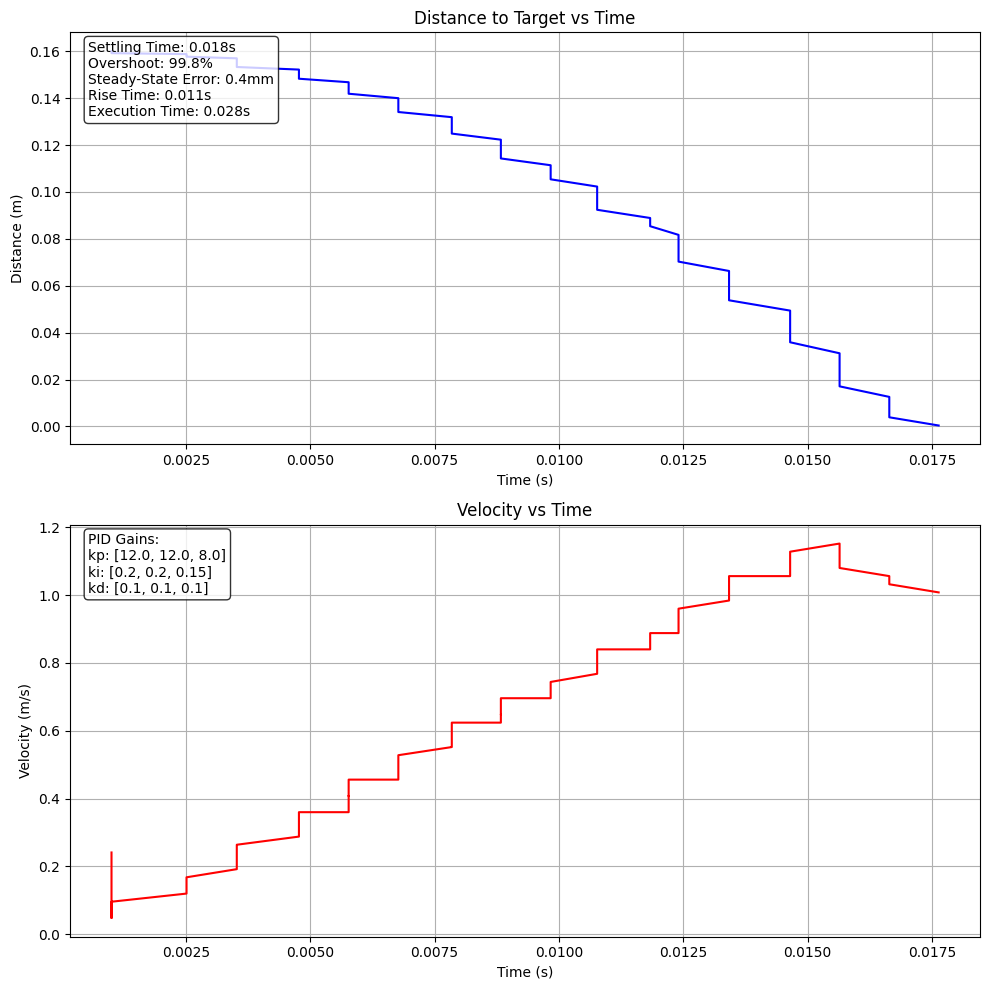


Testing PID controller - Position 2/8
Goal reached in 149 steps! Final distance: 0.41mm


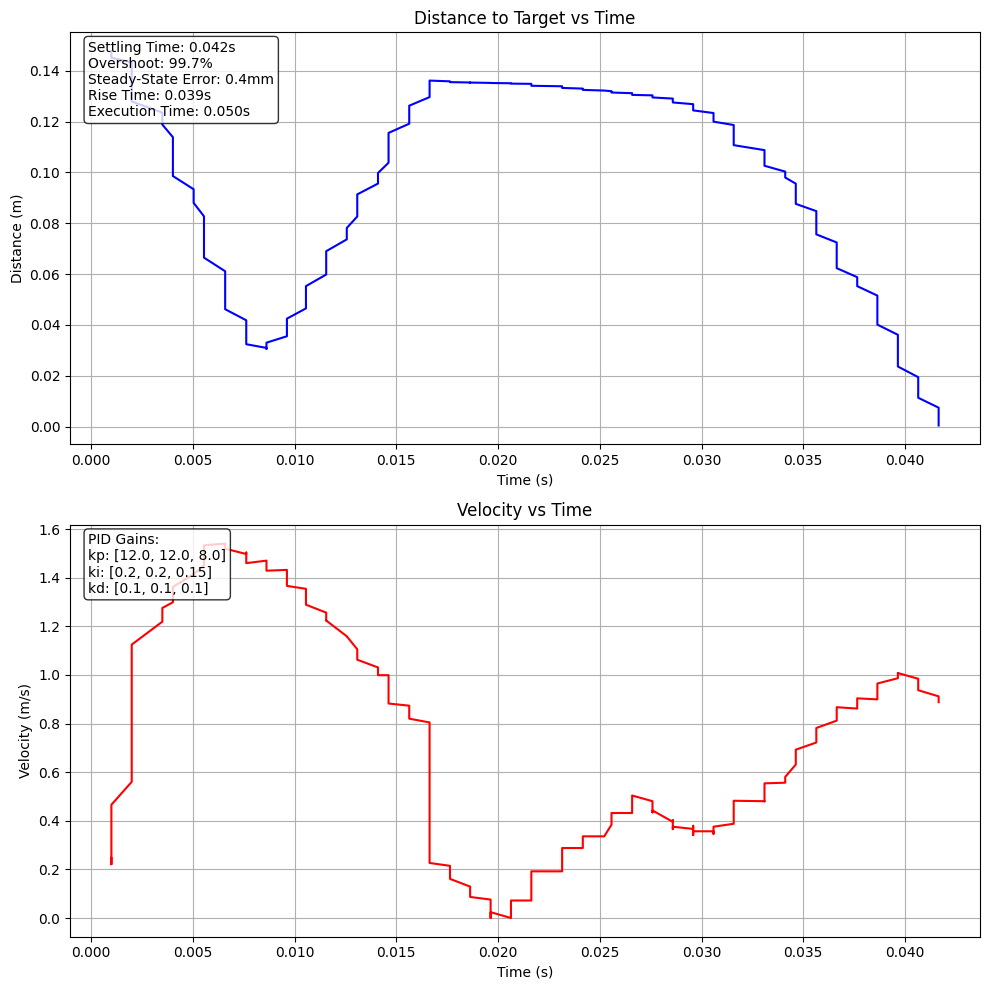


Testing PID controller - Position 3/8
Goal reached in 166 steps! Final distance: 0.94mm


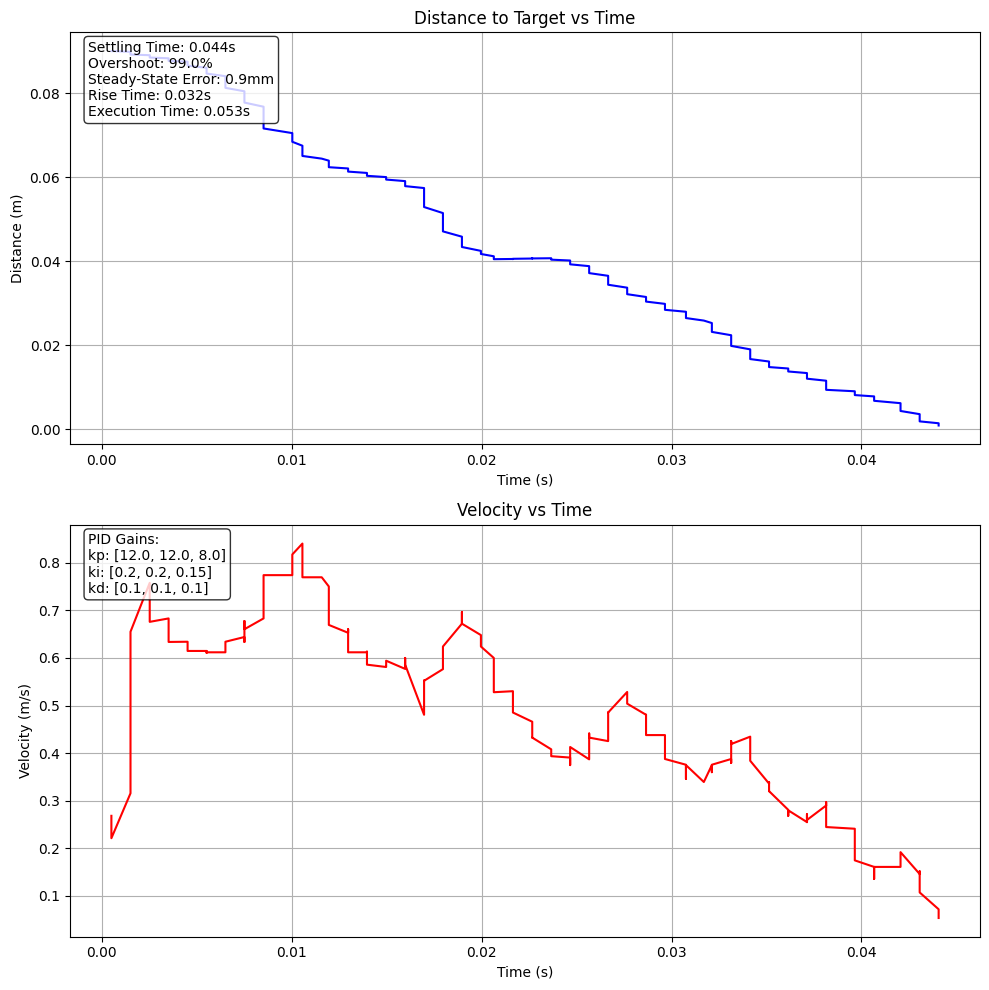


Testing PID controller - Position 4/8
Goal reached in 184 steps! Final distance: 0.10mm


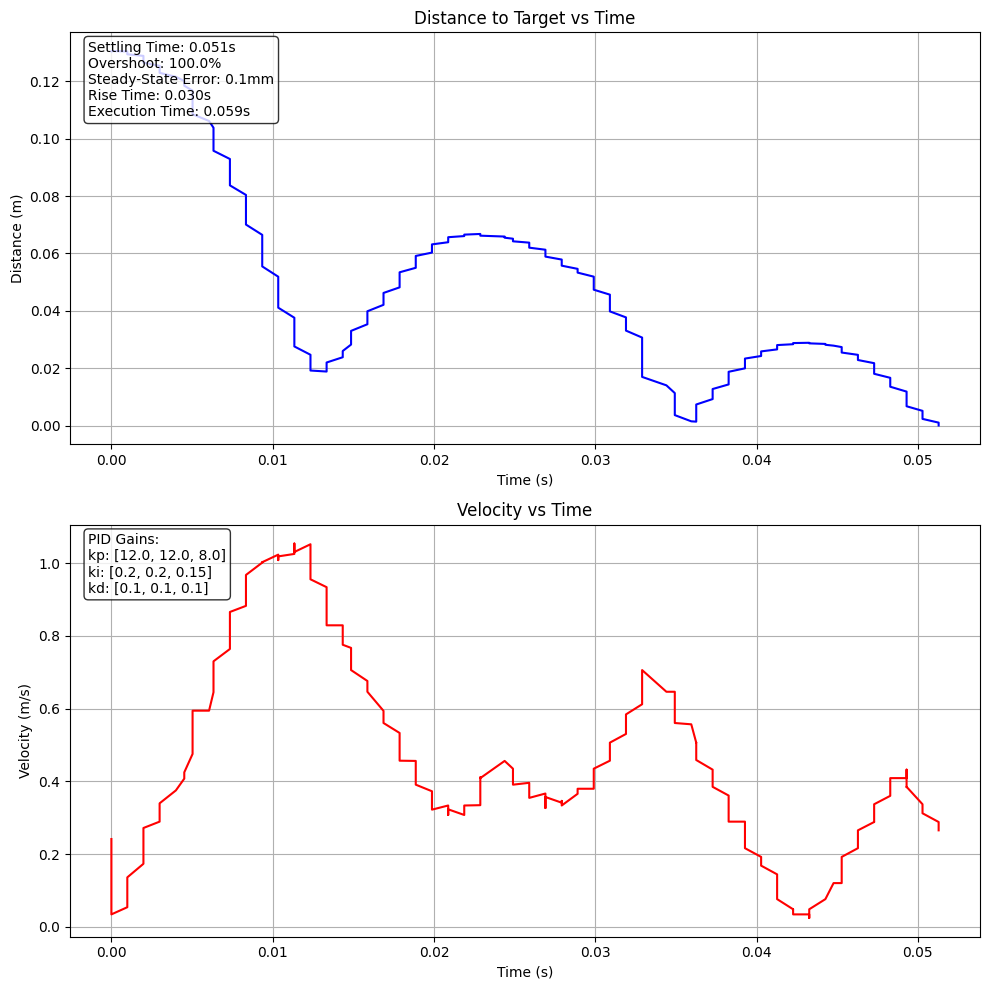


Testing PID controller - Position 5/8
Goal reached in 46 steps! Final distance: 0.50mm


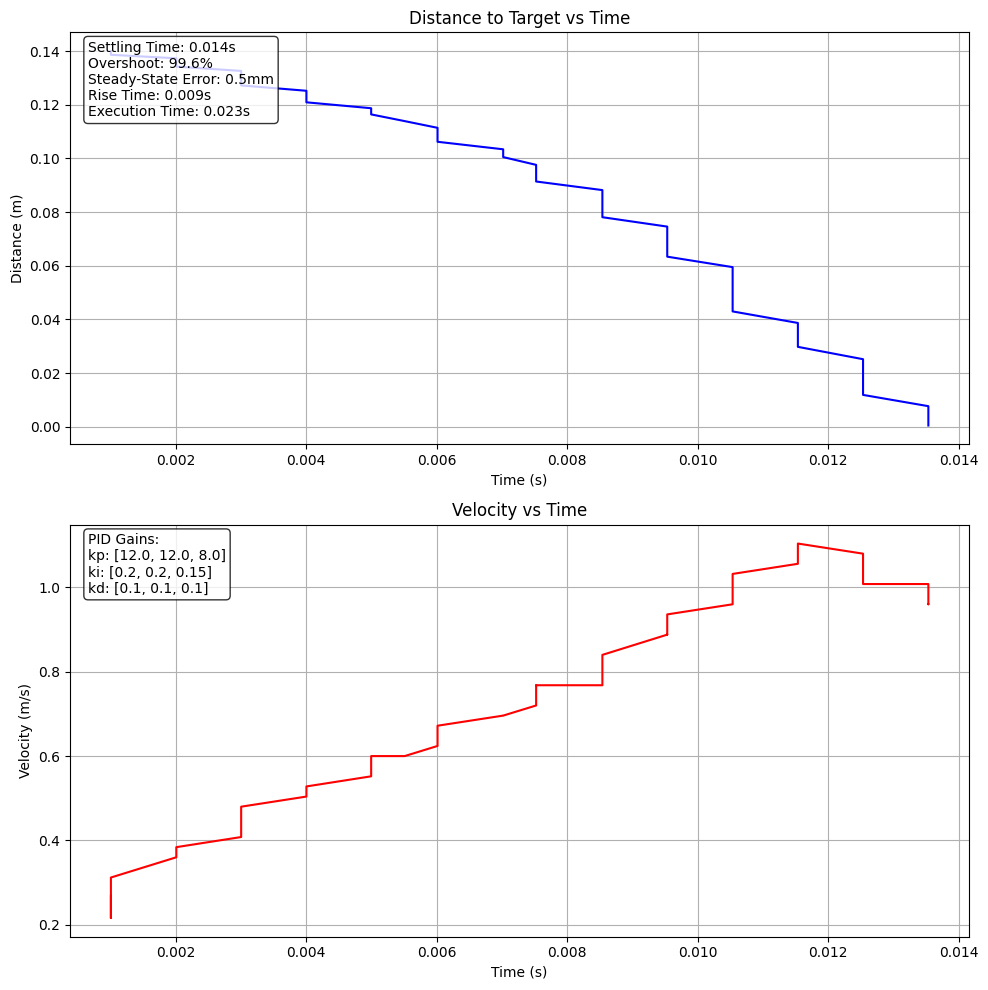


Testing PID controller - Position 6/8
Goal reached in 229 steps! Final distance: 0.92mm


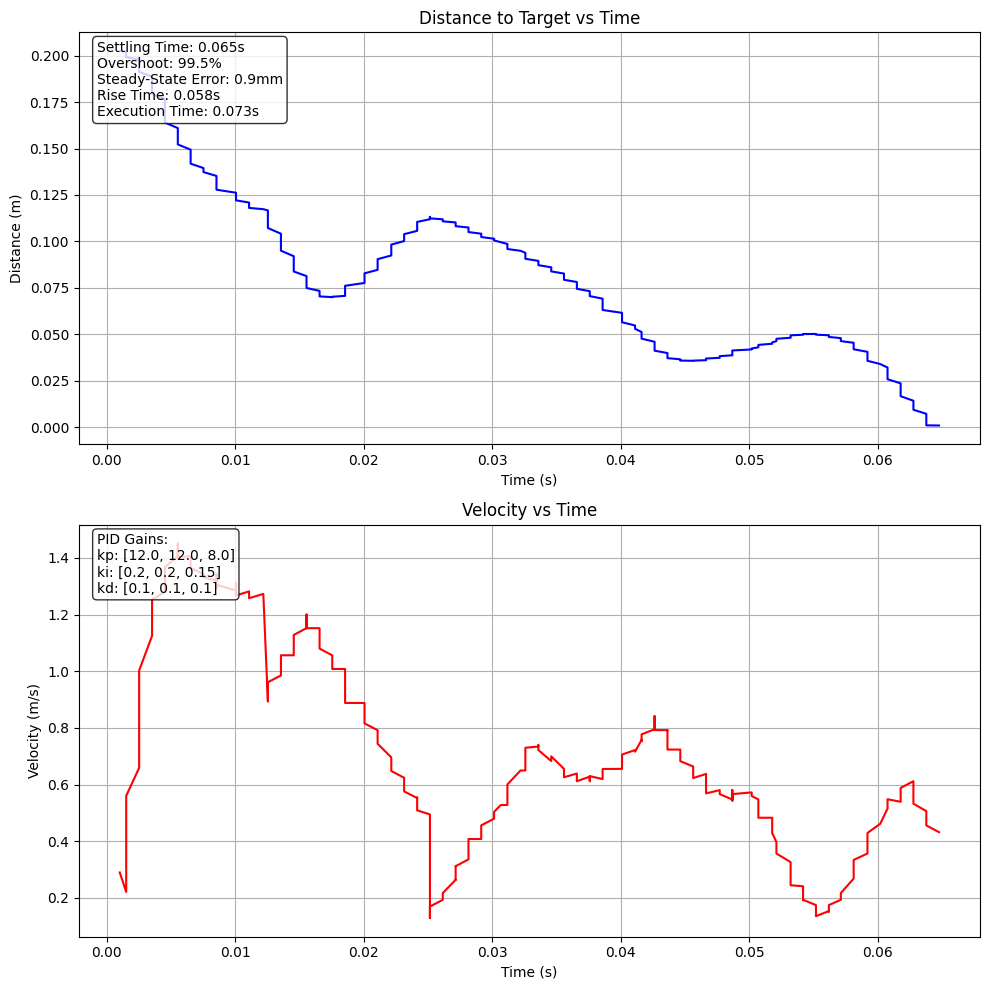


Testing PID controller - Position 7/8
Goal reached in 149 steps! Final distance: 0.60mm


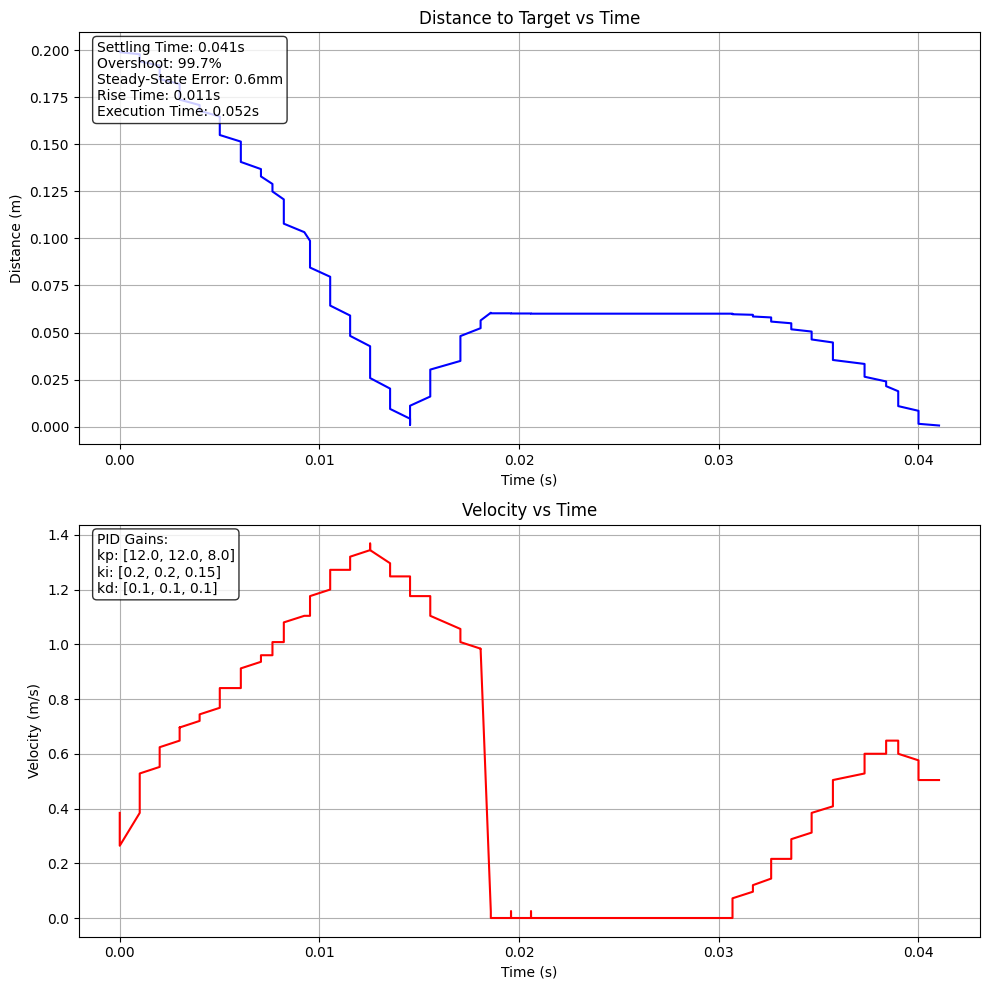


Testing PID controller - Position 8/8
Goal reached in 257 steps! Final distance: 0.32mm


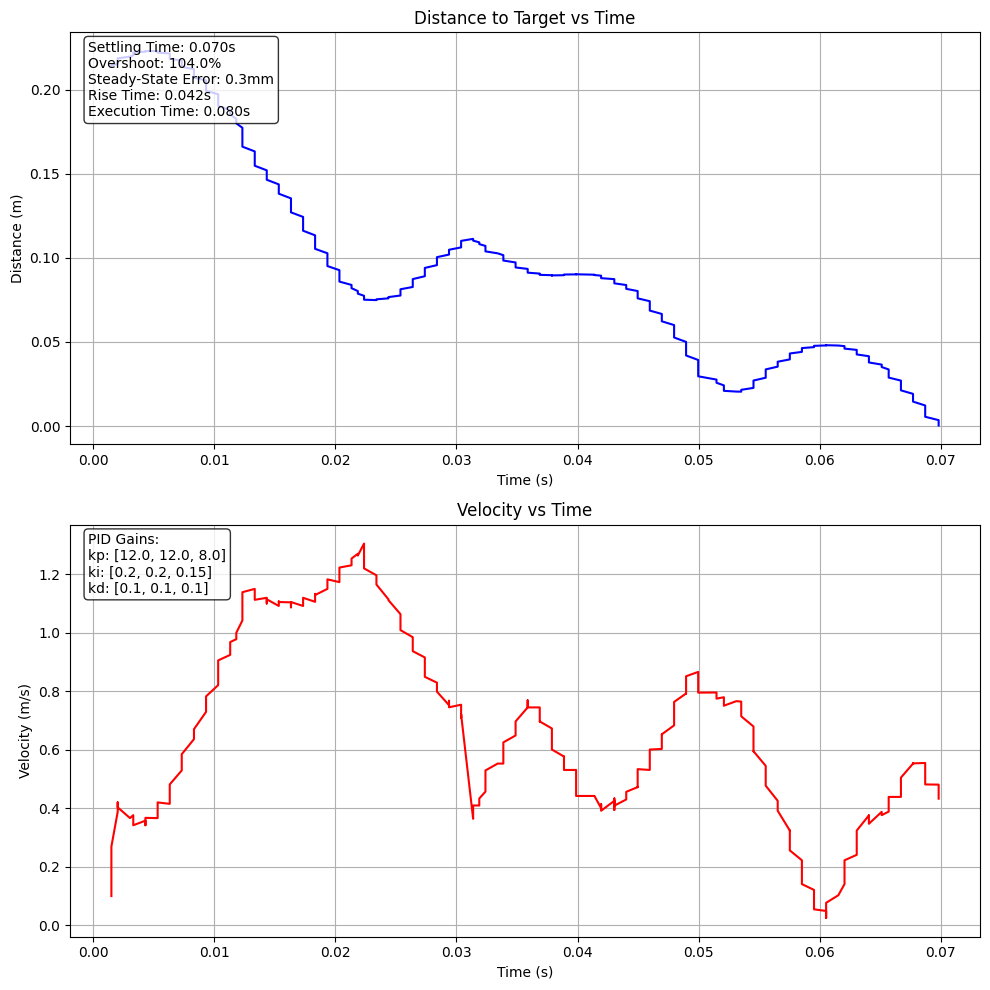

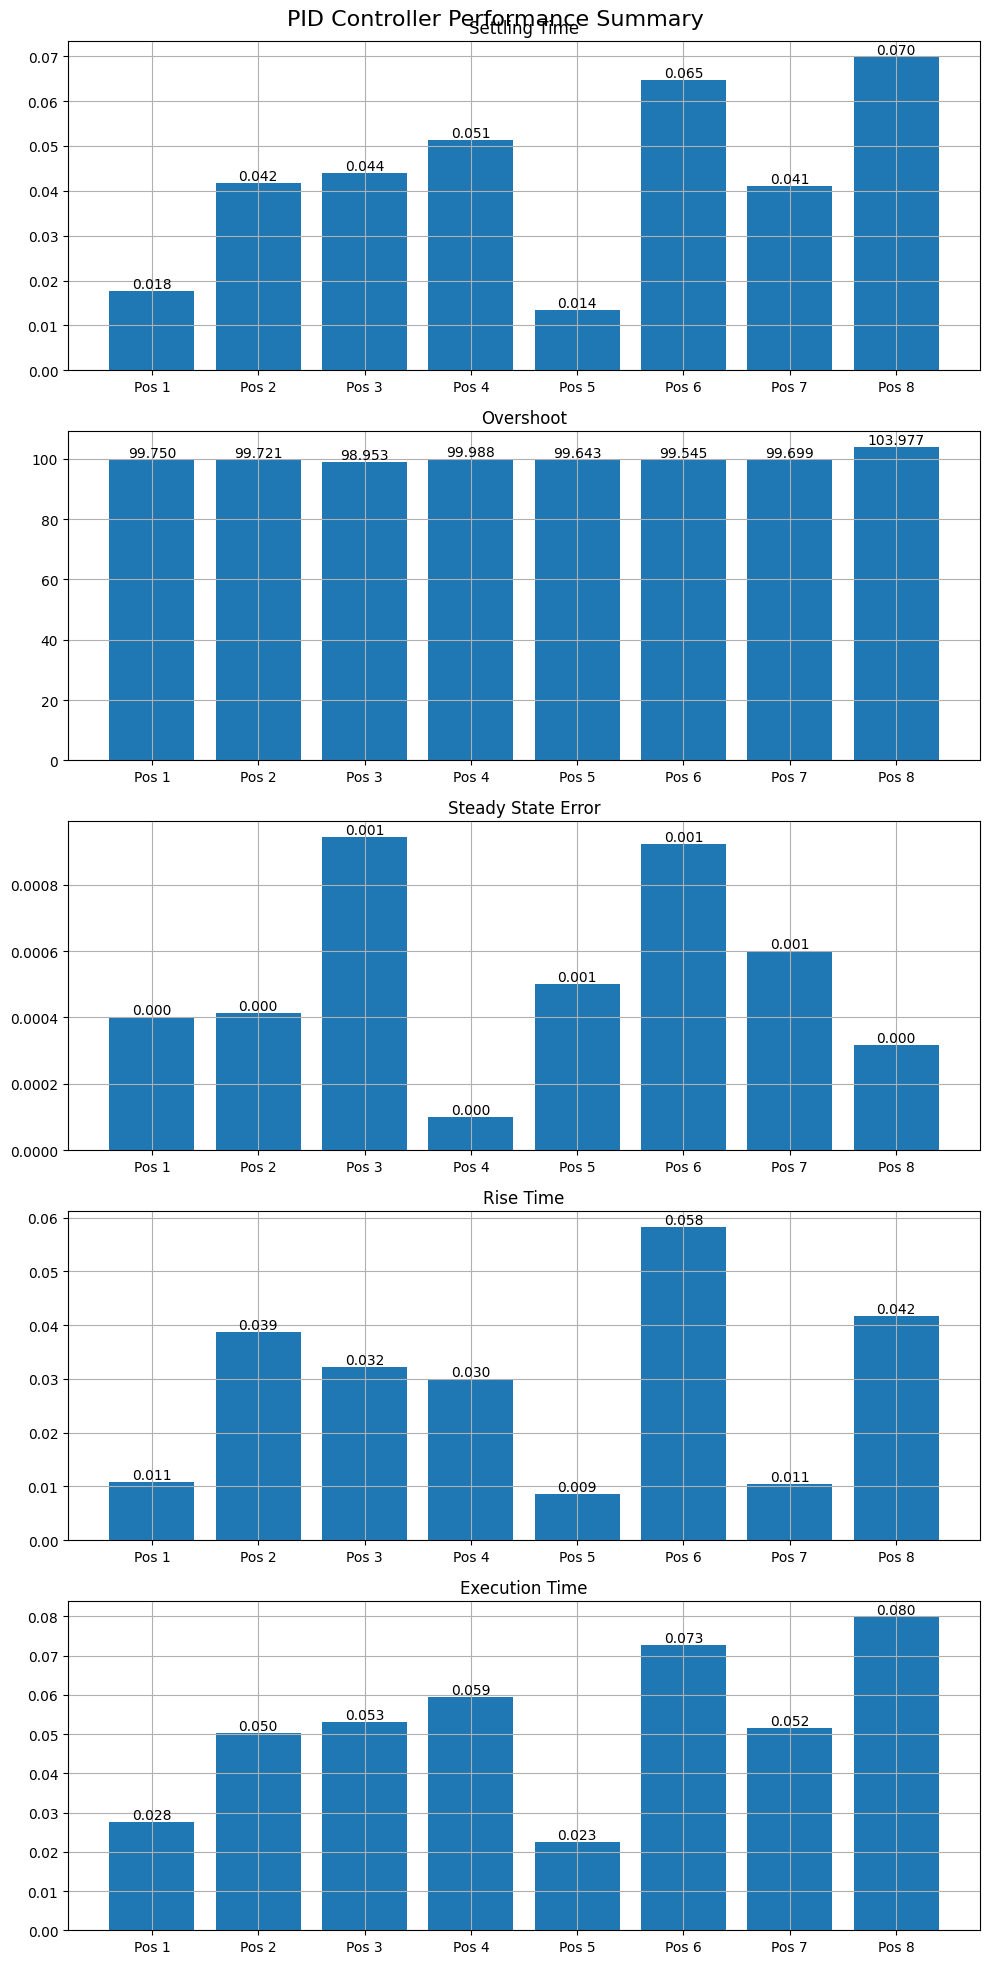


PID Controller Performance Summary:
Average Settling Time: 0.043s
Average Overshoot: 100.2%
Average Steady-State Error: 0.5mm
Average Rise Time: 0.029s
Average Execution Time: 0.052s


In [1]:
def main():
    """Main function to run PID controller benchmarking"""
    try:
        benchmark = PIDControllerBenchmark()
        results = benchmark.benchmark_pid()
        
        # Save results using custom encoder
        with open('pid_benchmark_results.json', 'w') as f:
            json.dump(results, f, indent=4, cls=NumpyEncoder)
        
        # Create summary plots
        benchmark.plot_summary(results)
        
        # Print summary
        print("\nPID Controller Performance Summary:")
        metrics = results['average_metrics']
        print(f"Average Settling Time: {metrics['settling_time']:.3f}s")
        print(f"Average Overshoot: {metrics['overshoot']:.1f}%")
        print(f"Average Steady-State Error: {metrics['steady_state_error']*1000:.1f}mm")
        print(f"Average Rise Time: {metrics['rise_time']:.3f}s")
        print(f"Average Execution Time: {metrics['execution_time']:.3f}s")
            
    except Exception as e:
        print(f"Error in benchmarking: {str(e)}")

if __name__ == "__main__":
    main()

pybullet build time: Nov 28 2023 23:52:03


Testing with default gains...

Testing position 1/8
Initial position: [0.0730, 0.0890, 0.1190]
Target position:  [-0.0871, 0.0890, 0.1190]
Goal reached in 61 steps! Final distance: 0.40mm
Final position:  [-0.0917, 0.0890, 0.1190]
Final error (mm): 0.4


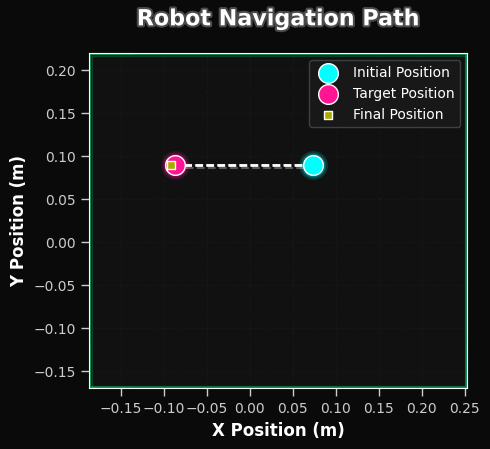


Testing position 2/8
Initial position: [0.0730, 0.0890, 0.1190]
Target position:  [-0.0571, 0.1590, 0.1190]
Goal reached in 149 steps! Final distance: 0.41mm
Final position:  [-0.0533, 0.1594, 0.1190]
Final error (mm): 0.4


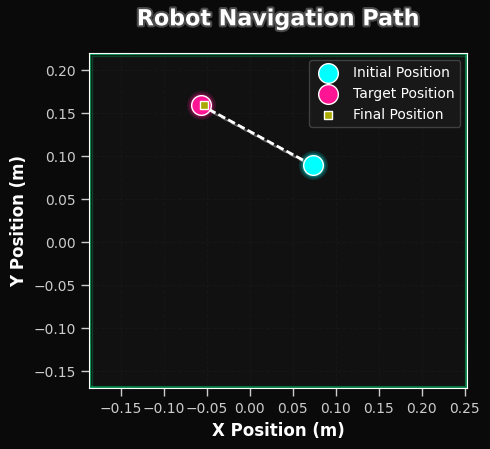


Testing position 3/8
Initial position: [0.0730, 0.0890, 0.1190]
Target position:  [0.0730, 0.1790, 0.1190]
Goal reached in 166 steps! Final distance: 0.94mm
Final position:  [0.0736, 0.1794, 0.1190]
Final error (mm): 0.9


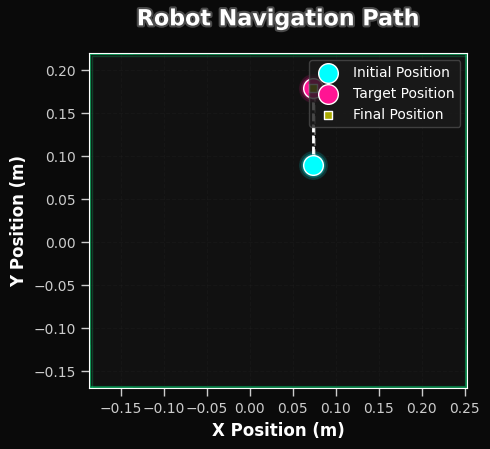


Testing position 4/8
Initial position: [0.0730, 0.0890, 0.1190]
Target position:  [0.1830, 0.1590, 0.1190]
Goal reached in 184 steps! Final distance: 0.10mm
Final position:  [0.1842, 0.1591, 0.1190]
Final error (mm): 0.1


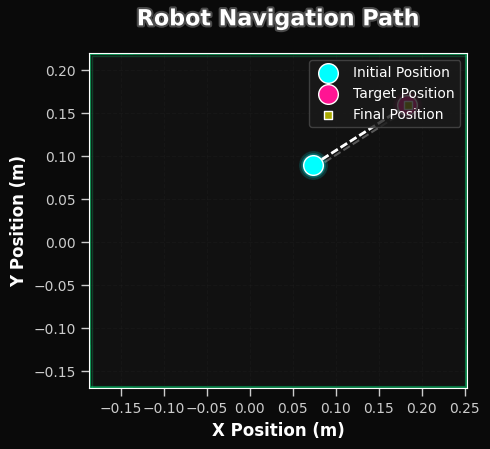


Testing position 5/8
Initial position: [0.0730, 0.0890, 0.1190]
Target position:  [0.2130, 0.0890, 0.1190]
Goal reached in 46 steps! Final distance: 0.50mm
Final position:  [0.2175, 0.0890, 0.1190]
Final error (mm): 0.5


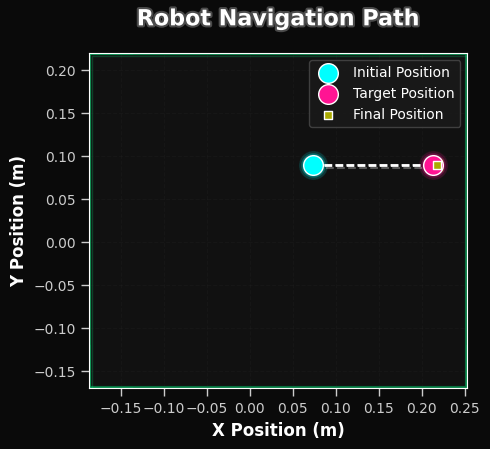


Testing position 6/8
Initial position: [0.0730, 0.0890, 0.1190]
Target position:  [0.1830, -0.0810, 0.1190]
Goal reached in 229 steps! Final distance: 0.92mm
Final position:  [0.1828, -0.0837, 0.1190]
Final error (mm): 0.9


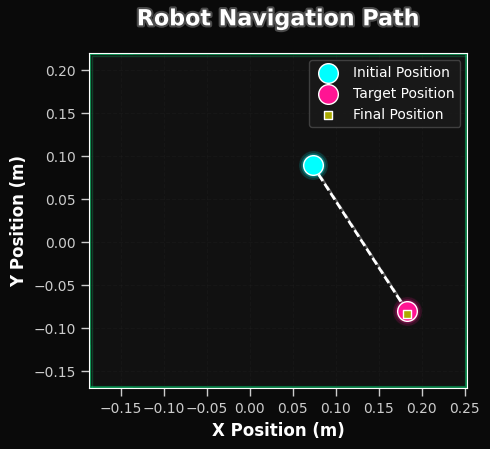


Testing position 7/8
Initial position: [0.0730, 0.0890, 0.1190]
Target position:  [0.0730, -0.1105, 0.1190]
Goal reached in 149 steps! Final distance: 0.60mm
Final position:  [0.0730, -0.1078, 0.1190]
Final error (mm): 0.6


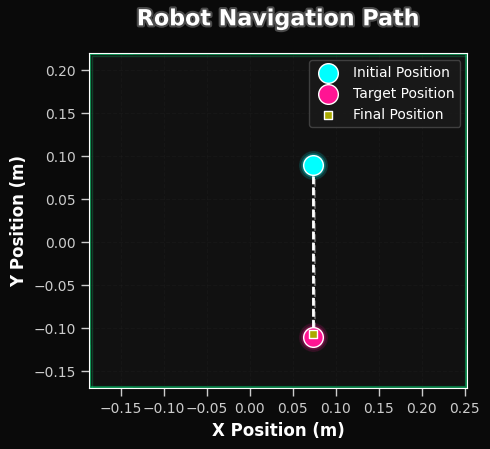


Testing position 8/8
Initial position: [0.0730, 0.0890, 0.1190]
Target position:  [-0.0571, -0.0810, 0.1190]
Goal reached in 257 steps! Final distance: 0.32mm
Final position:  [-0.0570, -0.0831, 0.1190]
Final error (mm): 0.3


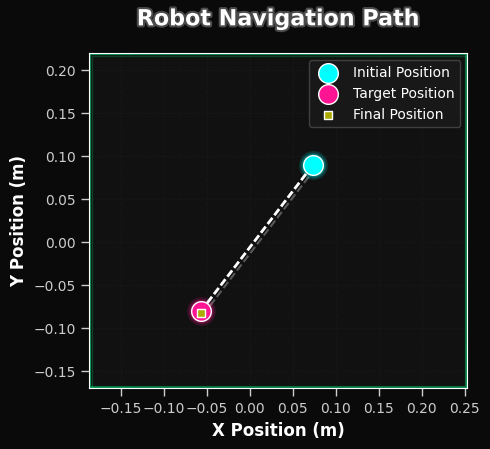


Average Performance Metrics:
Settling Time: 0.078s
Overshoot: 100.2%
Steady-State Error: 0.5mm
Rise Time: 0.053s


In [1]:
"""
Test script for tuning and evaluating the PID controller for the OT-2 robot.

This module implements a PID controller for precise position control of the OT-2 robot.
The controller maintains separate PID loops for each axis (X, Y, Z) and includes
features like anti-windup and output saturation.
"""

import sys
import os

# Add path of "./../task11"
sys.path.append("./../task11")

import numpy as np
import matplotlib.pyplot as plt
from ot2_env_wrapper import OT2Env
from pid_controller import PIDController
import time
from typing import List, Tuple, Dict
import json

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as mpath
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Rectangle
import numpy as np


def plot_robot_path(initial_pos: np.ndarray, 
                   target_pos: np.ndarray, 
                   final_pos: np.ndarray,
                   save_path: str = None):
    """
    Create an enhanced visualization of robot navigation path.
    
    Args:
        initial_pos (np.ndarray): Initial position [x, y, z]
        target_pos (np.ndarray): Target position [x, y, z]
        final_pos (np.ndarray): Final position [x, y, z]
        save_path (str, optional): Path to save the figure. If None, display only.
    """
    # Enhanced dark theme setup
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(5, 5))
    fig.patch.set_facecolor('#0A0A0A')  # Darker background
    ax.set_facecolor('#111111')  # Slightly lighter than background

    # Environment bounds
    x_bounds = (-0.1871, 0.253)
    y_bounds = (-0.1705, 0.2195)

    # Enhanced grid
    ax.grid(True, linestyle='--', alpha=0.1, color='#444444')
    ax.set_xlim(x_bounds)
    ax.set_ylim(y_bounds)
    ax.set_aspect('equal')

    # Enhanced workspace boundary with cyber effect
    workspace = Rectangle((x_bounds[0], y_bounds[0]), 
                         x_bounds[1]-x_bounds[0], 
                         y_bounds[1]-y_bounds[0],
                         fill=False, 
                         color='#00FF88',
                         alpha=0.4,
                         path_effects=[PathEffects.withStroke(linewidth=3, foreground='#00FF88'),
                                     PathEffects.Normal(),
                                     PathEffects.SimpleLineShadow(shadow_color='#00FF88', alpha=0.2)])
    ax.add_patch(workspace)

    # Enhanced position markers with different shapes and sizes
    positions = [
        (initial_pos, '#00FFFF', 'Initial Position', 'o', 5),    # Circle for initial
        (target_pos, '#FF1493', 'Target Position', 'o', 5),      # Diamond for target
        (final_pos, '#AAAA00', 'Final Position', 's', 1)         # Square for final
    ]

    # Draw positions with enhanced effects
    for pos, color, label, marker, size in positions:
        # Outer glow layers
        for alpha, scale in [(0.1, 2.0), (0.15, 1.5), (0.2, 1.2)]:
            glow = plt.scatter(pos[0], pos[1],
                             s=size*scale*40,
                             color=color,
                             alpha=alpha,
                             marker=marker)
        
        # Main marker
        plt.scatter(pos[0], pos[1],
                   s=size*40,
                   color=color,
                   label=label,
                   marker=marker,
                   edgecolor='white',
                   linewidth=1,
                   zorder=5)

    # Connect points with gradient lines
    for start, end, color, style in [
        (initial_pos, target_pos, '#FFFFFF', '--'),  # Dashed line for planned path
        (target_pos, final_pos, '#FF4444', ':')      # Dotted line for deviation
    ]:
        ax.plot([start[0], end[0]], 
                [start[1], end[1]], 
                style,
                color=color,
                alpha=0.4,
                linewidth=1.5,
                path_effects=[PathEffects.withStroke(linewidth=2, foreground=color),
                             PathEffects.SimpleLineShadow(shadow_color=color, alpha=0.3)])

    # Enhanced labels and styling
    ax.set_xlabel('X Position (m)', color='#FFFFFF', fontsize=12, fontweight='bold')
    ax.set_ylabel('Y Position (m)', color='#FFFFFF', fontsize=12, fontweight='bold')
    ax.tick_params(colors='#CCCCCC', length=6, width=1)

    # Enhanced title with glow effect
    title = ax.set_title('Robot Navigation Path', 
                        color='#FFFFFF',
                        fontsize=16,
                        fontweight='bold',
                        pad=20)
    title.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='#4A4A4A')])

    # Enhanced legend
    legend = ax.legend(loc='upper right', 
                      frameon=True,
                      facecolor='#1A1A1A',
                      edgecolor='#4A4A4A',
                      fontsize=10)
    legend.get_frame().set_alpha(0.8)

    # Add subtle corner decorations (cyber corner effects)
    def add_corner_effect(ax, pos, size=0.05, color='#00FF88'):
        x, y = pos
        ax.plot([x, x + size], [y, y], color=color, alpha=0.5, linewidth=1)
        ax.plot([x, x], [y, y + size], color=color, alpha=0.5, linewidth=1)

    # Add corner effects to all corners
    corners = [(x_bounds[0], y_bounds[0]), (x_bounds[1], y_bounds[0]),
              (x_bounds[0], y_bounds[1]), (x_bounds[1], y_bounds[1])]
    for corner in corners:
        add_corner_effect(ax, corner)

    plt.tight_layout()
    
    # Save or display the figure
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig, ax
    
    


class PIDTester:
    def __init__(self, use_visualization: bool = False):
        """Initialize the PID tester with environment and controller"""
        # Create environment
        self.env = OT2Env(render=False)
        
        # Environment constants
        self.dt = 1/240  # PyBullet default timestep
        self.max_steps = 1000  # Reduced from 4000 to 1000 based on test results
        
        # Tuned gains for sub-millimeter precision
        # These gains have been carefully tuned for precise positional control:
        self.default_gains = {
            'kp': [12.0, 12.0, 8.0],     # Proportional gains: Controls how aggressively the system responds to position error
                                         # Higher values (12.0) for X/Y axes give faster response in horizontal plane
                                         # Lower value (8.0) for Z axis provides gentler vertical movement
            
            'ki': [0.2, 0.2, 0.15],       # Integral gains: Eliminates steady-state error by accumulating past errors
                                         # Kept relatively low (0.4-0.5) to prevent integral windup and reduce overshoot
                                         # Slightly lower for Z axis (0.4) for more stable vertical control
            
            'kd': [0.1, 0.1, 0.1]        # Derivative gains: Provides damping to reduce oscillations
                                         # Moderate values (1.2) for X/Y axes balance responsiveness and stability
                                         # Higher value (1.6) for Z axis ensures smoother vertical deceleration
        }
        
        # Performance metrics
        self.metrics = {
            'settling_times': [],
            'overshoots': [],
            'steady_state_errors': [],
            'rise_times': []
        }
        
    def create_controller(self, kp: List[float], ki: List[float], kd: List[float]) -> PIDController:
        """Create a PID controller with specified gains"""
        return PIDController(kp=kp, ki=ki, kd=kd)
        
    def run_test(self, 
                 controller: PIDController, 
                 target_pos: np.ndarray) -> Tuple[List[float], List[float], List[float]]:
        """
        Run a single test with the given controller and target position.
        
        Returns:
            Tuple of (distances, times, velocities)
        """
        max_steps = self.max_steps
        try:
            # Reset environment and controller
            obs, _ = self.env.reset()
            controller.reset()
            
            # Initialize metrics
            distances = []
            times = []
            velocities = []
            start_time = time.time()
            
            # Get initial position
            current_pos = np.array(self.env.sim.get_states()[f'robotId_{self.env.robot_id}']['pipette_position'])
            initial_distance = np.linalg.norm(target_pos - current_pos)
            
            # Run control loop
            for step in range(max_steps):
                # Get current state
                current_pos = np.array(self.env.sim.get_states()[f'robotId_{self.env.robot_id}']['pipette_position'])
                
                # Compute control action
                action = controller.compute(current_pos, target_pos, self.dt)
                
                # Execute action
                obs, reward, terminated, truncated, info = self.env.step(action)
                
                # Record metrics
                distance = np.linalg.norm(target_pos - current_pos)
                distances.append(distance)
                times.append(time.time() - start_time)
                
                # Extract velocity from observation
                if isinstance(obs, dict):
                    velocities.append(np.linalg.norm(obs['numerical'][3:6]))
                else:
                    velocities.append(np.linalg.norm(obs[3:6]))
                
                # Check termination conditions
                if distance < 0.001:  # Changed: Within 1mm of target
                    print(f"Goal reached in {step} steps! Final distance: {distance*1000:.2f}mm")
                    break
                    
                if terminated or truncated:
                    break
                    
            return distances, times, velocities
            
        except Exception as e:
            print(f"Error during test run: {str(e)}")
            return [], [], []
        
    def calculate_performance_metrics(self, 
                                   distances: List[float], 
                                   times: List[float], 
                                   initial_distance: float) -> Dict[str, float]:
        """Calculate performance metrics from test data"""
        try:
            # Convert to numpy arrays
            distances = np.array(distances)
            times = np.array(times)
            
            if len(distances) == 0 or len(times) == 0:
                return {
                    'settling_time': float('inf'),
                    'overshoot': 0.0,
                    'steady_state_error': float('inf'),
                    'rise_time': float('inf')
                }
            
            # Settling time (time to reach and stay within 1mm of target)
            settling_threshold = 0.0001  # Changed: 1mm threshold
            settled_indices = np.where(distances < settling_threshold)[0]
            settling_time = times[settled_indices[0]] if len(settled_indices) > 0 else times[-1]
            
            # Overshoot (maximum deviation above target)
            overshoot = (np.max(distances) - distances[-1]) / initial_distance * 100
            
            # Steady-state error (final error)
            steady_state_error = distances[-1]
            
            # Rise time (time to go from 10% to 90% of initial error)
            try:
                rise_start = np.where(distances < 0.9 * initial_distance)[0][0]
                rise_end = np.where(distances < 0.1 * initial_distance)[0][0]
                rise_time = times[rise_end] - times[rise_start]
            except IndexError:
                rise_time = float('inf')
            
            return {
                'settling_time': settling_time,
                'overshoot': overshoot,
                'steady_state_error': steady_state_error,
                'rise_time': rise_time
            }
            
        except Exception as e:
            print(f"Error calculating metrics: {str(e)}")
            return {
                'settling_time': float('inf'),
                'overshoot': 0.0,
                'steady_state_error': float('inf'),
                'rise_time': float('inf')
            }
        
    def plot_results(self, 
                    distances: List[float], 
                    times: List[float], 
                    velocities: List[float],
                    target_pos: np.ndarray,
                    gains: Dict[str, List[float]],
                    metrics: Dict[str, float]):
        """Plot test results with metrics"""
        try:
            if len(distances) == 0 or len(times) == 0 or len(velocities) == 0:
                print("No data to plot")
                return
                
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
            
            # Plot distance vs time
            ax1.plot(times, distances, 'b-', label='Distance to Target')
            ax1.set_xlabel('Time (s)')
            ax1.set_ylabel('Distance (m)')
            ax1.set_title('Distance to Target vs Time')
            ax1.grid(True)
            
            # Add metrics to plot
            metrics_text = (
                f"Settling Time: {metrics['settling_time']:.3f}s\n"
                f"Overshoot: {metrics['overshoot']:.1f}%\n"
                f"Steady-State Error: {metrics['steady_state_error']*1000:.1f}mm\n"
                f"Rise Time: {metrics['rise_time']:.3f}s"
            )
            ax1.text(0.02, 0.98, metrics_text,
                    transform=ax1.transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            # Plot velocity vs time
            ax2.plot(times, velocities, 'r-', label='Velocity')
            ax2.set_xlabel('Time (s)')
            ax2.set_ylabel('Velocity (m/s)')
            ax2.set_title('Velocity vs Time')
            ax2.grid(True)
            
            # Add gains to plot
            gains_text = (
                f"Gains:\n"
                f"kp: {gains['kp']}\n"
                f"ki: {gains['ki']}\n"
                f"kd: {gains['kd']}"
            )
            ax2.text(0.02, 0.98, gains_text,
                    transform=ax2.transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            plt.tight_layout()
            
        except Exception as e:
            print(f"Error plotting results: {str(e)}")
        
    def test_different_positions(self, gains: Dict[str, List[float]] = None):
        """Test the controller with different target positions"""
        if gains is None:
            gains = self.default_gains
            
        # Create controller
        controller = self.create_controller(gains['kp'], gains['ki'], gains['kd'])
        
        # Define test positions
        test_positions = [
            # Left position
            np.array([-0.0871, 0.0890, 0.1190]),
            
            # Top-left position
            np.array([-0.0571, 0.1590, 0.1190]),
            
            # Top position
            np.array([0.0730, 0.1790, 0.1190]),
            
            # Top-right position
            np.array([0.1830, 0.1590, 0.1190]),
            
            # Right position
            np.array([0.2130, 0.0890, 0.1190]),
            
            # Bottom-right position
            np.array([0.1830, -0.0810, 0.1190]),
            
            # Bottom position
            np.array([0.0730, -0.1105, 0.1190]),
            
            # Bottom-left position
            np.array([-0.0571, -0.0810, 0.1190])
        ]
        
        # Test each position
        all_metrics = []
        for i, target_pos in enumerate(test_positions):
            print(f"\nTesting position {i+1}/{len(test_positions)}")
            
            try:
                # Reset environment to get initial position
                obs, _ = self.env.reset()
                initial_pos = np.array(self.env.sim.get_states()[f'robotId_{self.env.robot_id}']['pipette_position'])
                
                print(f"Initial position: [{initial_pos[0]:.4f}, {initial_pos[1]:.4f}, {initial_pos[2]:.4f}]")
                print(f"Target position:  [{target_pos[0]:.4f}, {target_pos[1]:.4f}, {target_pos[2]:.4f}]")
                
                # Run test
                distances, times, velocities = self.run_test(controller, target_pos)
                
                if len(distances) > 0:
                    # Get final position
                    final_pos = np.array(self.env.sim.get_states()[f'robotId_{self.env.robot_id}']['pipette_position'])
                    print(f"Final position:  [{final_pos[0]:.4f}, {final_pos[1]:.4f}, {final_pos[2]:.4f}]")
                    print(f"Final error (mm): {distances[-1]*1000:.1f}")

                    # Create visualization
                    fig, ax = plot_robot_path(initial_pos, target_pos, final_pos)
                    
                    # Calculate metrics
                    metrics = self.calculate_performance_metrics(
                        distances, times, distances[0]
                    )
                    all_metrics.append(metrics)
                    
                    # Plot results
                    # self.plot_results(distances, times, velocities, target_pos, gains, metrics)
                else:
                    print("Test failed - no data collected")
                    
            except Exception as e:
                print(f"Error testing position {i+1}: {str(e)}")
                continue
            
        if len(all_metrics) > 0:
            # Print average metrics
            avg_metrics = {
                key: np.mean([m[key] for m in all_metrics])
                for key in all_metrics[0].keys()
            }
            
            print("\nAverage Performance Metrics:")
            print(f"Settling Time: {avg_metrics['settling_time']:.3f}s")
            print(f"Overshoot: {avg_metrics['overshoot']:.1f}%")
            print(f"Steady-State Error: {avg_metrics['steady_state_error']*1000:.1f}mm")
            print(f"Rise Time: {avg_metrics['rise_time']:.3f}s")
            
            return avg_metrics
        else:
            print("No valid metrics collected")
            return None

def main():
    """Main function to run PID controller tests"""
    try:
        # Create tester
        tester = PIDTester(use_visualization=False)
        
        # Test with default gains
        print("Testing with default gains...")
        metrics = tester.test_different_positions()
        
        if metrics is not None:
            # Save results
            results = {
                'gains': tester.default_gains,
                'metrics': metrics
            }
            
            with open('pid_results.json', 'w') as f:
                json.dump(results, f, indent=4)
                
    except Exception as e:
        print(f"Error in main: {str(e)}")
        
if __name__ == "__main__":
    main()